This is not the main notebook in this challenge. See `sft-train-d20.ipynb`.

## Look into observations

Look into observations from the training run. The question I want to get to is did the run "work"? The fact that validation loss ended worse than it started makes me think no, but maybe it's not that simple.

### Number of tokens

Number of tokens was roughly 10,000 plus/minus a few thousand per step which means very roughly (divide by number of ranks) 1250 per rank which means very roughly (divide by batch size) 300 supervised tokens per conversationn. If say half of tokens are supervised, that means the average conversation is 600 tokens. That doesn't seem crazy. From when I hit that error in challenge 28 training on my mac due to a conversation being longer than 1280 tokens I know there are plenty of conversations that are less. Anyway, we can just look.

How many "supervised" training tokens should there be in a single epoch? Copy some code from `my_chat_sft.py`.

In [1]:
import sys
sys.path.append('../my_nanochat')
import os
import torch
from my_nanochat.my_common import get_base_dir
from my_nanochat.my_tokenizer import get_tokenizer
from my_tasks.my_arc import MyARC
from my_tasks.my_smoltalk import MySmolTalk
from my_tasks.my_customjson import MyCustomJSON
from my_tasks.my_spellingbee import MySimpleSpelling, MySpellingBee
from my_tasks.my_common import MyTaskMixture
from my_tasks.my_gsm8k import MyGSM8K

In [2]:
base_dir = get_base_dir()
identity_conversations_filepath = os.path.join(base_dir, "identity_conversations.jsonl")
train_ds = MyTaskMixture([
    MyARC(subset="ARC-Easy", split="train"), # 2.3K rows
    MyARC(subset="ARC-Challenge", split="train"), # 1.1K rows
    MyGSM8K(subset="main", split="train"), # 8K rows
    MySmolTalk(split="train", stop=10_000), # 10K rows of smoltalk
    MyCustomJSON(filepath=identity_conversations_filepath), # 1K rows of synthetic identity conversations
    MySimpleSpelling(size=300, split="train"), # 300 rows of Simple Spelling (e.g. spell the word 'apple')
    MySpellingBee(size=300, split="train"), # 300 rows of Spelling Bee (e.g. how many 'r' are in 'strawberry'?)
]) # 2.3K + 1.1K + 8K + 10K + 1K + 0.3K + 0.3K = 23K rows

In [3]:
tokenizer = get_tokenizer()

In [4]:
device = torch.get_default_device()
def sft_data_generator(dataset, batch_size, fake_ddp_rank, fake_ddp_world_size):
    pad_token_id = tokenizer.encode_special("<|assistant_end|>")
    def collate_and_yield(batch):
        nrows = len(batch)
        ncols = max(len(ids) for ids, _ in batch) - 1
        inputs = torch.full((nrows, ncols), pad_token_id, dtype=torch.long)
        targets = torch.full((nrows, ncols), -1, dtype=torch.long)
        for i, (ids, mask) in enumerate(batch):
            n = len(ids)
            ids_tensor = torch.tensor(ids, dtype=torch.long)
            inputs[i, :n-1] = ids_tensor[:-1]
            row_targets = ids_tensor[1:]
            mask_tensor = torch.tensor(mask[1:], dtype=torch.long)
            row_targets[mask_tensor == 0] = -1
            targets[i, :n-1] = row_targets
        inputs = inputs.to(device)
        targets = targets.to(device)
        return inputs, targets
    batch = []
    while True:
        for i in range(fake_ddp_rank, len(dataset), fake_ddp_world_size):
            doc = dataset[i]
            ids, mask = tokenizer.render_conversation(doc)  # what if it's too long?
            batch.append((ids, mask))
            if len(batch) == batch_size:
                yield collate_and_yield(batch)
                batch = []

In [7]:
target_examples_per_step = 32
num_epochs = 1
num_iterations = (len(train_ds) // target_examples_per_step) * num_epochs
train_loader = sft_data_generator(train_ds, batch_size=4, fake_ddp_rank=0, fake_ddp_world_size=8)
total_supervised_tokens = 0
fake_step = 0
while fake_step < num_iterations:
    inputs, targets = next(train_loader)
    num_supervised_tokens = (targets > 0).sum().item()
    total_supervised_tokens += num_supervised_tokens
    if fake_step % 25 == 0:
        print(f"step {fake_step}: {num_supervised_tokens} supervised tokens from:")
        for i in range(inputs.size(0)):
            start_of_conversation = tokenizer.decode(inputs[i].tolist())[:50]
            num_supervised_tokens_for_this_conversation = (targets[i] > 0).sum()
            print(f"  {i}: {start_of_conversation} ({num_supervised_tokens_for_this_conversation})")
    fake_step += 1        

step 0: 1346 supervised tokens from:
  0: <|bos|><|user_start|>A woman is trying to decide w (164)
  1: <|bos|><|user_start|>Peter carried $500 to the mar (135)
  2: <|bos|><|user_start|>In business settings, I often (925)
  3: <|bos|><|user_start|>Bob can shuck 10 oysters in 5 (122)
step 25: 1162 supervised tokens from:
  0: <|bos|><|user_start|>For every bike Henry sells, h (58)
  1: <|bos|><|user_start|>hi there<|user_end|><|assista (309)
  2: <|bos|><|user_start|>Consider the heat equation on (793)
  3: <|bos|><|user_start|>Multiple Choice question: Whe (2)
step 50: 1591 supervised tokens from:
  0: <|bos|><|user_start|>I have being given a new lead (898)
  1: <|bos|><|user_start|>A snail is at the bottom of a (570)
  2: <|bos|><|user_start|>Tenisha had 40 dogs that she  (121)
  3: <|bos|><|user_start|>Multiple Choice question: A g (2)
step 75: 547 supervised tokens from:
  0: <|bos|><|user_start|>HI THERE!!<|user_end|><|assis (273)
  1: <|bos|><|user_start|>Bonny just bought her 1

One thing that jumps out is my assumption that about half of tokens are supervised is very wrong for these multiple choice ones. There the model needs to read lots of tokens but only two are supervised: the letter and end assistant.

In [14]:
# average number of tokens per step for rank 0
total_supervised_tokens // num_iterations

1351

In [15]:
# asuming all ranks about the same
8 * 1351

10808

So I do think the number of supervised tokens shown in the training run is expected.

I wonder if we do more epochs in the bigger [run1000.sh](https://github.com/karpathy/nanochat/blob/master/run1000.sh)? No.

A lot of parameter updating is "powered" by these relatively small number of tokens. For example take step 25 conversation 1 which is multiple choice. Suppose the model assigns a low probability to the correct answer. That "signal" makes up something like 1/32nd or 1/64th of backprop calculations. Wait...is that true? Is loss computed per row and averaged or is the batch flattened first? It's weird becuase that didn't matter before when we were packing batches and counting all tokens the same, but now with padding and all these ignore index things in the targets it does.

In my_gpt.py we do: `loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1, reduction=loss_reduction)`

So we *do* flatten. This means every supervised tokens counts the same. Not sure if this makes more or less sense. It means each of the 793 supervised tokens from step 25 conversation 2 has as much influence as the 2 tokens in conversation 3. That's certainly not true for a student learning in school. If you could improve yourself to improve a few words in the essay response portion of a test or to get a multiple choice question correct you would want to do the second.

Another weird thing is that all supervised tokens count the same for loss within a rank, but later we average gradients across ranks. So if for example on a single step a single rank had 8 supervised tokens, and on that same step another rank had 2000 supervised tokens, the 8 would count just as much as the 2000.

Because of the way the datasets are and the TaskMixture works I'm sure that never happens, but just to get a feel for this, collect the numbers for all ranks and all steps:

In [31]:
supervised_token_counts = torch.zeros((701, 8), dtype=torch.int32)
target_examples_per_step = 32
num_epochs = 1
num_iterations = (len(train_ds) // target_examples_per_step) * num_epochs
for fake_ddp_rank in range(0, 8):
    train_loader = sft_data_generator(train_ds, batch_size=4, fake_ddp_rank=fake_ddp_rank, fake_ddp_world_size=8)
    fake_step = 0
    while fake_step < num_iterations:
        inputs, targets = next(train_loader)
        supervised_token_counts[fake_step, fake_ddp_rank] = (targets > 0).sum()
        fake_step += 1

In [32]:
supervised_token_counts

tensor([[1346, 1307, 2251,  ...,  379, 1612, 1304],
        [1257, 2214, 4318,  ...,  600,  786, 1421],
        [1599,  420, 1701,  ..., 1339, 2391, 1291],
        ...,
        [ 698,  805,  416,  ..., 2151, 1286, 1030],
        [ 827, 1674,  789,  ...,  315, 2462, 1488],
        [ 105, 1604, 2044,  ..., 1996, 1702,  323]], dtype=torch.int32)

In [36]:
# check total per step matches what we saw in the run
supervised_token_counts.sum(dim=1)[:10]

tensor([ 9718, 13979, 11283, 12682,  9509,  8344,  8763, 10664, 11584,  9920])

^ yes, matches

In [44]:
supervised_token_counts.max(), supervised_token_counts.min()

(tensor(4665, dtype=torch.int32), tensor(8, dtype=torch.int32))

^ funny, we do end up with at least one rank/step with only 8 tokens

In [93]:
(supervised_token_counts <= 8).sum()

tensor(2)

In [95]:
(supervised_token_counts <= 100).sum()

tensor(32)

In [37]:
from matplotlib import pyplot as plt

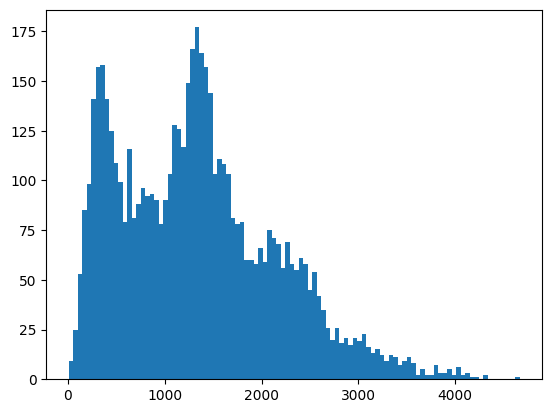

In [97]:
plt.hist(supervised_token_counts.flatten(), bins=100);

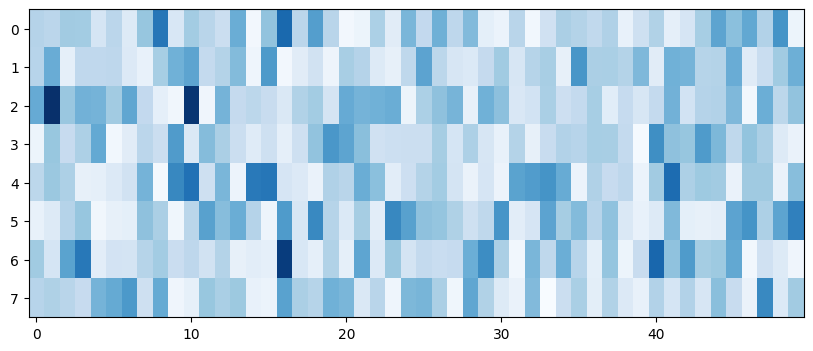

In [90]:
# look at first 50 steps across 8 ranks
plt.figure(figsize=(10, 4))
plt.imshow(supervised_token_counts[:50].T, cmap="Blues", aspect="auto")
plt.show()

In [84]:
supervised_token_counts[1]

tensor([1257, 2214, 4318, 1708, 1675,  600,  786, 1421], dtype=torch.int32)

^ so light means low and dark means high

Without thinking super carefully, understanding some of this stuff makes me think it's not so weird for training loss to jump around so much with each step.

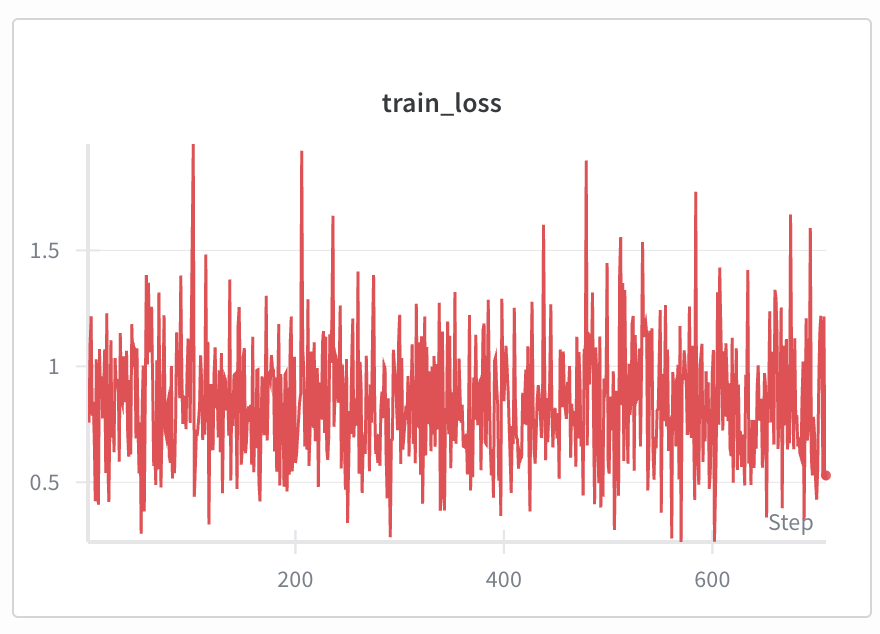

### Validation loss

Why does the validation loss do this is it bad?

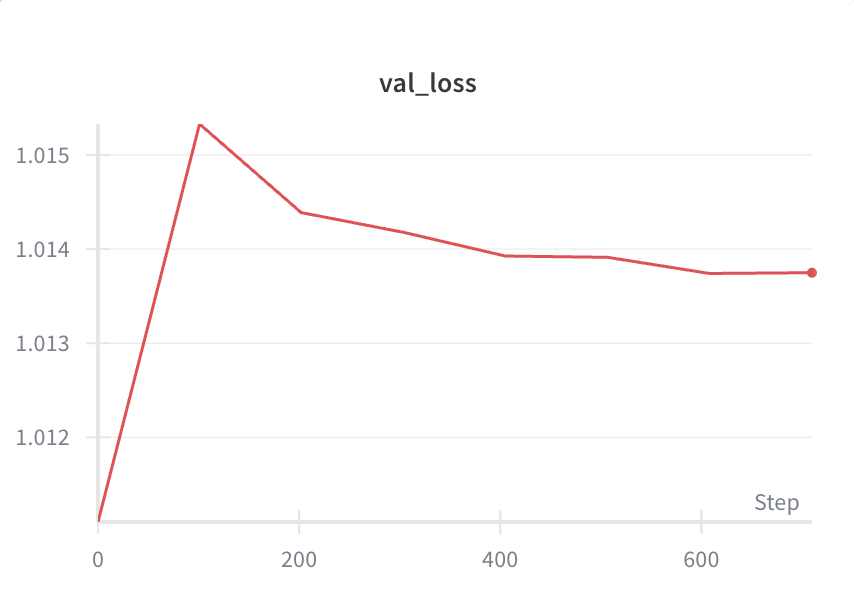

Val loss uses: ```val_ds = MySmolTalk(split="test")```. Look at examples from SmolTalk in `challenge-26-understand-midtrain/midtrain-data-examples.ipynb`.

I don't know if it's bad that val loss goes from 1.011 before training starts to 1.015 at step 100. SmolTalk data is just one part of the mix (~43%) of training data. Are we giving the model a "shock" by training it in this whole new supervised way? Maybe when back on the GPU machine do the evaluation every 25 steps and see what's going on between step 0 and 100.

### SpellingBee

Accuracy of SpellingBee goes from 97.27% on mid to 95.70% on sft. This doesn't seem shocking. SimpleSpelling and SpellingBee together are 33% of the training data for mid measured by rows, but for sft they are only 2.6%, so in getting better at other things the model might lose some of being good at the spelling stuff. Also, and really unsure how to think about this, but we don't count the python output part towards the loss in sft and so it probably gets a little worse at "playing computer" and predicting the python output, and maybe it's learned to copy that python output to the final answer.

Ooh! I've been assuming we're just not up to the model being able to use python yet. That's totally wrong. `chat_eval` uses the engine which knows how to use the calculator, **EXCEPT** I didn't implement that part of the engine yet (the handle tool logic). There's no point in looking into this accuracy stuff until I do that.

However, before doing that that, I'm curious to see a few correct HumanEval conversations:

### HumanEval

In [102]:
import sys
sys.path.append('../my_nanochat')
from my_tasks.humaneval import HumanEval
from my_nanochat.my_checkpoint_manager import load_model
from my_nanochat.my_common import compute_init, autodetect_device_type
from my_nanochat.my_engine import Engine

In [103]:
val_task = HumanEval()

In [104]:
device_type = autodetect_device_type() 
_, _, _, _, device = compute_init(device_type)
model, tokenizer, meta_data = load_model('sft', model_tag='d20', device=device, phase='eval')
engine = Engine(model, tokenizer)

Autodetected device type: mps
loading the model from /Users/ericsilberstein/.cache/my_nanochat/chatsft_checkpoints/d20 with step 700
Building model with config: {'sequence_len': 2048, 'vocab_size': 65536, 'n_layer': 20, 'n_head': 10, 'n_kv_head': 10, 'n_embd': 1280}


In [105]:
val_task[0]

{'messages': [{'role': 'user',
   'content': '\n\ndef below_threshold(l: list, t: int):\n    """Return True if all numbers in the list l are below threshold t.\n    >>> below_threshold([1, 2, 4, 10], 100)\n    True\n    >>> below_threshold([1, 20, 4, 10], 5)\n    False\n    """\n'},
  {'role': 'assistant',
   'content': '\n\ndef below_threshold(l: list, t: int):\n    """Return True if all numbers in the list l are below threshold t.\n    >>> below_threshold([1, 2, 4, 10], 100)\n    True\n    >>> below_threshold([1, 20, 4, 10], 5)\n    False\n    """\n\n    for e in l:\n        if e >= t:\n            return False\n    return True\n'}],
 'entry_point': 'below_threshold',
 'test': '\n\nMETADATA = {}\n\n\ndef check(candidate):\n    assert candidate([1, 2, 4, 10], 100)\n    assert not candidate([1, 20, 4, 10], 5)\n    assert candidate([1, 20, 4, 10], 21)\n    assert candidate([1, 20, 4, 10], 22)\n    assert candidate([1, 8, 4, 10], 11)\n    assert not candidate([1, 8, 4, 10], 10)\n\n'}

In [106]:
def print_conversation(conversation):
    for message in conversation['messages']:
        print(f"_____{message['role']}_____")
        content = message['content']
        if isinstance(content, str):
            print(content)
        else:
            assert isinstance(content, list)
            for part in content:
                print(f"{part['type']}: {part['text']}")
        print()

In [107]:
print_conversation(val_task[0])

_____user_____


def below_threshold(l: list, t: int):
    """Return True if all numbers in the list l are below threshold t.
    >>> below_threshold([1, 2, 4, 10], 100)
    True
    >>> below_threshold([1, 20, 4, 10], 5)
    False
    """


_____assistant_____


def below_threshold(l: list, t: int):
    """Return True if all numbers in the list l are below threshold t.
    >>> below_threshold([1, 2, 4, 10], 100)
    True
    >>> below_threshold([1, 20, 4, 10], 5)
    False
    """

    for e in l:
        if e >= t:
            return False
    return True




In [108]:
tokens = tokenizer.render_for_completion(val_task[0])

In [109]:
tokenizer.decode(tokens)

'<|bos|><|user_start|>\n\ndef below_threshold(l: list, t: int):\n    """Return True if all numbers in the list l are below threshold t.\n    >>> below_threshold([1, 2, 4, 10], 100)\n    True\n    >>> below_threshold([1, 20, 4, 10], 5)\n    False\n    """\n<|user_end|><|assistant_start|>'

In [110]:
results, _ = engine.generate_batch(tokens, max_tokens=512, top_k=50, temperature=0.0)

In [111]:
print(tokenizer.decode(results[0]))

<|bos|><|user_start|>

def below_threshold(l: list, t: int):
    """Return True if all numbers in the list l are below threshold t.
    >>> below_threshold([1, 2, 4, 10], 100)
    True
    >>> below_threshold([1, 20, 4, 10], 5)
    False
    """
<|user_end|><|assistant_start|>def below_threshold(l, t):
    """Return True if all numbers in the list l are below threshold t.
    """
    return all(n < t for n in l)
```

This function uses a generator expression to iterate over the list and check if each number is less than the threshold. If all numbers are below the threshold, the function returns True; otherwise, it returns False.<|assistant_end|>


In [112]:
l, t = [1, 2, 4, 10], 100
all(n < t for n in l)

True

In [113]:
l, t = [1, 20, 4, 10], 5
all(n < t for n in l)

False

Well, it got that one right, and it didn't just memorize since it used a different approach. I wonder why we don't do train/test split for HumanEval?

Look at one more for fun.

In [114]:
print_conversation(val_task[1])

_____user_____

def check_if_last_char_is_a_letter(txt):
    '''
    Create a function that returns True if the last character
    of a given string is an alphabetical character and is not
    a part of a word, and False otherwise.
    Note: "word" is a group of characters separated by space.

    Examples:
    check_if_last_char_is_a_letter("apple pie") ➞ False
    check_if_last_char_is_a_letter("apple pi e") ➞ True
    check_if_last_char_is_a_letter("apple pi e ") ➞ False
    check_if_last_char_is_a_letter("") ➞ False 
    '''


_____assistant_____

def check_if_last_char_is_a_letter(txt):
    '''
    Create a function that returns True if the last character
    of a given string is an alphabetical character and is not
    a part of a word, and False otherwise.
    Note: "word" is a group of characters separated by space.

    Examples:
    check_if_last_char_is_a_letter("apple pie") ➞ False
    check_if_last_char_is_a_letter("apple pi e") ➞ True
    check_if_last_char_is_a_letter("a

In [115]:
tokens = tokenizer.render_for_completion(val_task[1])
results, _ = engine.generate_batch(tokens, max_tokens=512, top_k=50, temperature=0.0)
print(tokenizer.decode(results[0]))

<|bos|><|user_start|>
def check_if_last_char_is_a_letter(txt):
    '''
    Create a function that returns True if the last character
    of a given string is an alphabetical character and is not
    a part of a word, and False otherwise.
    Note: "word" is a group of characters separated by space.

    Examples:
    check_if_last_char_is_a_letter("apple pie") ➞ False
    check_if_last_char_is_a_letter("apple pi e") ➞ True
    check_if_last_char_is_a_letter("apple pi e ") ➞ False
    check_if_last_char_is_a_letter("") ➞ False 
    '''
<|user_end|><|assistant_start|>Here's a Python function that checks if the last character of a given string is an alphabetical character and is not a part of a word:

```python
def check_if_last_char_is_a_letter(txt):
    """
    Create a function that returns True if the last character of a given string is an alphabetical character and is not a part of a word, and False otherwise.
    Note: "word" is a group of characters separated by space.

    Example

^ Well that's not going to work :)

### Add tool calling to Engine

I'll do that in new challenge 31 then get back to the GPU machine and repeat the chat evals.